    Bastien KATUSZYNSKI - Maxime LEFEBVRE

## #1-Collecte des données

In [2]:
import sys
import random
import requests
import shutil
import os
import string
from pandas import json_normalize
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import urllib.parse

endpoint_url = "https://query.wikidata.org/sparql"
# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }
}
LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )

dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)

def download_image(url):
    folder = "images/"
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        # Extract the filename from the URL and decode it
        filename = urllib.parse.unquote(os.path.basename(url))

        # Remove any query parameters from the filename
        filename, _ = os.path.splitext(filename)
        
        # Remove any special characters from the filename
        valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
        filename = ''.join(c for c in filename if c in valid_chars)
        filename = "img_" + filename
        # Extract the extension from the URL and add it to the filename
        extension = os.path.splitext(url)[1]
        filename += extension
        with open(folder + filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


dataframe.image.apply(download_image)

0     200
1     200
2     200
3     200
4     200
     ... 
95    200
96    200
97    200
98    200
99    200
Name: image, Length: 100, dtype: int64

In [1]:
from PIL import Image
import os
import json
import sys
import random
import requests
import shutil
import string
from pandas import json_normalize
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import urllib.parse

def writeJsonInformations(jsonData):
    with open("images_informations.json", "w") as f:
        json.dump(jsonData, f, indent=4, ensure_ascii=False)
        print("Les informations ont été enregistrés dans le fichier JSON")

In [2]:
from PIL import Image
import os
import json
import sys
import random
import requests
import shutil
import string
from pandas import json_normalize
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import urllib.parse

# Chemin du dossier à parcourir
folder_path = "./images"

# Liste des propriétés de chaque image
images = []

# Parcours des fichiers du dossier
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)
    if os.path.isfile(filepath):
        # Vérifie si le fichier est une image
        if filepath.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            # Ouverture de l'image
            with Image.open(filepath) as img:
                # Récupération des propriétés de l'image
                
                imgfile = Image.open(filepath)
            
                size = img.size
                format = img.format
                exif_data = imgfile._getexif()
                
                if exif_data is not None:
                    # Récupération des informations Exif spécifiques
                    image_width = exif_data.get(256)
                    image_height = exif_data.get(257)
                    orientation = exif_data.get(274)
                    creation_date = exif_data.get(306)
                    camera_model = exif_data.get(531)
                
                    # Ajout des propriétés à la liste des images
                    images.append({
                        "filename": filename,
                        "size": size,
                        "heigth": image_height,
                        "width": image_width,
                        "format": format,
                        "orientation": orientation,
                        "creation_date":creation_date,
                        "camera_model": camera_model
                    })
                    
                # Ajout des propriétés à la liste des images
                images.append({
                    "filename": filename,
                    "size": size,
                    "format": format
                })
                

writeJsonInformations(images)


Les informations ont été enregistrés dans le fichier JSON


## #2-Etiquetage et Annotation

In [11]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
import os
import json
import sys
import random
import requests
import shutil
import string
from pandas import json_normalize
import pandas as pd
import webcolors
import reverse_geocode
import pycountry
import piexif

# Calcul de distance des couleurs
def color_distance(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2
    return math.sqrt((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2)

# Récupération des tags de couleurs
def get_tags_colors(imgfile):
    tags = []
    # Liste des propriétés de chaque image
    images = []
    numberOfCluster = 5
    
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    # Effectuer le clustering avec numberOfCluster clusters
    clusters = KMeans(n_clusters=numberOfCluster, n_init=2)
    clusters.fit(numarray)

    # Définir les limites des bins
    npbins = numpy.arange(0, numberOfCluster+1)
    histogram = numpy.histogram(clusters.labels_, bins=numpy.arange(0, numberOfCluster+1))

    dominant_colors = clusters.cluster_centers_
    frequency = histogram[0]
    
    # trier les couleurs dominantes en fonction de leur fréquence décroissante
    sorted_idx = numpy.argsort(frequency)[::-1]
    sorted_colors = dominant_colors[sorted_idx]
    hex_colors = []
    color = ""
    """ Trop long à executer
    red = histogram[0:255]
    green = histogram[256:511]
    blue = histogram[512:767]
    # Calcul des totaux de valeurs pour chaque canal
    total_red = sum(red)
    total_green = sum(green)
    total_blue = sum(blue)

    # Comparaison des totaux pour récupérer la couleur la plus présente
    if total_red >= total_green and total_red >= total_blue:
        color = 'red'
    elif total_green >= total_red and total_green >= total_blue:
        color = 'green'
    else:
        color = 'blue'
    """
    # Parmi les 3 couleurs dominantes
    for color in sorted_colors[:3]:
        hex_color = '#%02x%02x%02x' % (
            math.ceil(color[0]),
            math.ceil(color[1]),
            math.ceil(color[2])
        )
        """ Trop long à executer
        # Récupérer une liste de couleurs prédéfinies
        colors = webcolors.CSS3_HEX_TO_NAMES

        # Initialiser les variables de distance minimale et de couleur la plus proche
        min_distance = float('inf')
        closest_color = None

        
        # Parcourir chaque couleur prédéfinie et calculer sa distance avec la couleur de référence
        for hex_code, name in colors.items():
            rgb_code = webcolors.hex_to_rgb(hex_code)
            distance = color_distance(color, rgb_code)

            # Si la distance est plus petite que la distance minimale actuelle, mettre à jour la couleur la plus proche
            if distance < min_distance:
                min_distance = distance
                closest_color = name
        """
        # Afficher la couleur la plus proche
        #tags.append(closest_color)
        tags.append(hex_color)
        
    return tags, color
    
def get_image_country(exif_data):
    if exif_data is not None:
        # Récupération des informations de géolocalisation
        gps_info = exif_data.get(34853)
        if type(gps_info) is not None: 
            try:
                lat = gps_info[2][0][0] / float(gps_info[2][0][1])
                lon = gps_info[4][0][0] / float(gps_info[4][0][1])
                coordinates = (lat, lon)
                # Traduction des coordonnées GPS en nom de lieu
                location_info = reverse_geocode.search(coordinates)[0]
                # Récupération du code de pays ISO 3166-1 alpha-2 à partir du nom de lieu
                country_name = location_info.get('country', None)
                if country_name is not None:
                    country = pycountry.countries.get(name=country_name)
                    if country is not None:
                        return country.alpha_2
            except: 
                print("Ne peut pas ajouter le nom du pays d'origine")
        
    return None

def get_mode_image(imgfile):
    # Déterminer le format de l'image
    tags = ""
    if imgfile is not None: 
        width, height = imgfile.size
        if width > height:
            tags = "paysage"
        elif width < height:
            tags = "portrait"
        else:
            tags = "carre"
    return tags



In [24]:

from PIL import Image
import os
import json
import sys
import random
import requests
import shutil
import string
from pandas import json_normalize
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import urllib.parse
import multiprocessing

# Chemin du dossier à parcourir
folder_path = "./images"

# Liste des propriétés de chaque image
images = []

index = 0

def process_image(filepath):
    # Vérifie si le fichier est une image
    if filepath.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
        # Ouverture de l'image
        with Image.open(filepath) as img:
            # Récupération des propriétés de l'image

            imgfile = Image.open(filepath)

            size = img.size
            format = img.format
            exif_data = imgfile._getexif()

            if exif_data is not None:
                # Récupération des informations Exif spécifiques
                image_width = exif_data.get(256)
                image_height = exif_data.get(257)
                orientation = exif_data.get(274)
                creation_date = exif_data.get(306)
                camera_model = exif_data.get(531)
                country = get_image_country(exif_data)
                
                mode_image = get_mode_image(imgfile)
                
                most_RGB_color = ""
                tags = []
                #Trop long à executer
                #tags, most_RGB_color = get_tags_colors(imgfile)  

                # Ajout des propriétés à la liste des images
                return {
                    "filename": os.path.basename(filepath),
                    "size": size,
                    "heigth": image_height,
                    "width": image_width,
                    "mode":mode_image,
                    "format": format,
                    "orientation": orientation,
                    "creation_date":creation_date,
                    "camera_model": camera_model,
                    "country" : country,
                    "most_RGB_color": most_RGB_color,
                    "tags": tags
                }
            else: 
                # Ajout des propriétés à la liste des images
                return {
                    "filename": os.path.basename(filepath),
                    "size": size,
                    "heigth": "",
                    "width": "",
                    "mode":"",
                    "format": format,
                    "orientation": "",
                    "creation_date":"",
                    "camera_model": "",
                    "country" : "",
                    "most_RGB_color": "",
                    "tags": ""
                }

def process_folder(folder_path):
    # Création d'un pool de processus
    pool = multiprocessing.Pool()

    # Parcours des fichiers du dossier en utilisant le pool de processus
    results = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            result = pool.apply_async(process_image, (filepath,))
            results.append(result)

    # Fermeture du pool de processus et attente de la fin des traitements
    pool.close()
    pool.join()

    # Récupération des résultats
    images = []
    for result in results:
        image = result.get()
        if image is not None:
            images.append(image)

    return images

# Appel de la fonction process_folder
images = process_folder(folder_path)
                    

writeJsonInformations(images)

Ne peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origine


Ne peut pas ajouter le nom du pays d'origine
Ne peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origine
Ne peut pas ajouter le nom du pays d'origine

Ne peut pas ajouter le nom du pays d'origine

Ne peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origine


Ne peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origine

Ne peut pas ajouter le nom du pays d'origine
Ne peut pas ajouter le nom du pays d'origine
Ne peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origineNe peut pas ajouter le nom du pays d'origine

Ne peut pas ajouter le nom du pays d'origine
Ne peut pas ajouter le nom du pays d'origine

Ne peut pas ajouter le nom du pays d'origineNe peut pas

## #-4 Visualisation des données

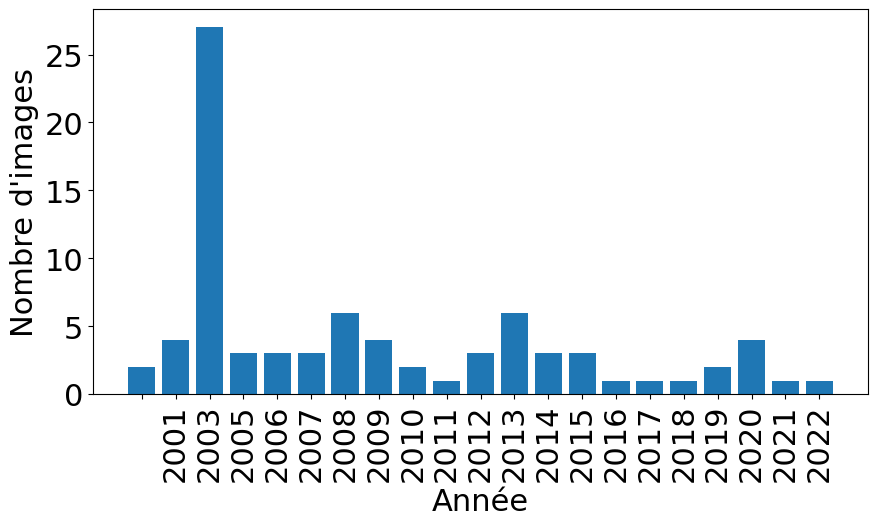

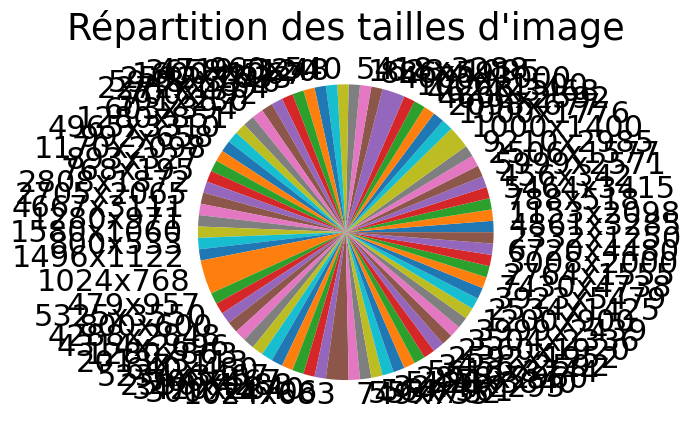

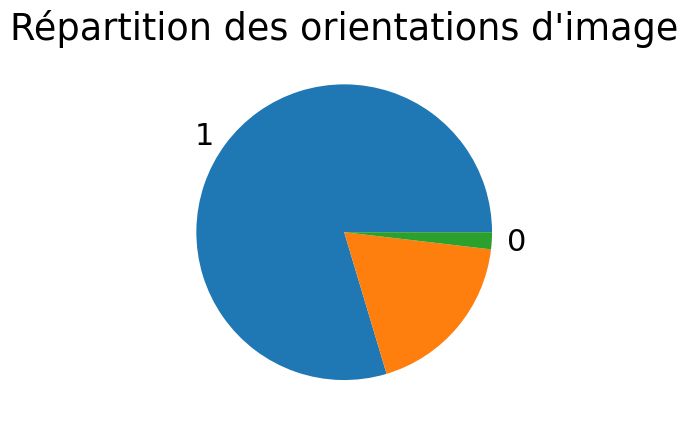

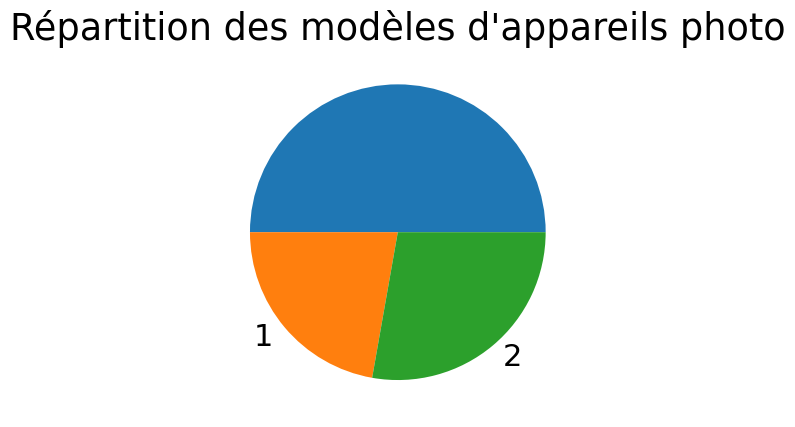

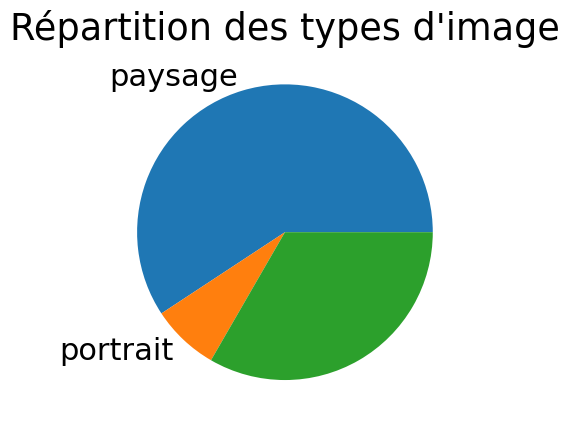

In [39]:
from PIL import Image
import os
import json
import sys
import random
import requests
import shutil
import string
from pandas import json_normalize
import pandas as pd
import urllib.parse
import multiprocessing
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(10, 5))

# Ouverture du fichier JSON contenant les données exif
with open('images_informations.json', 'r') as f:
    data = json.load(f)

# Initialisation du dictionnaire pour compter le nombre d'images par année
images_per_year = defaultdict(int)
# Création de compteurs pour chaque caractéristique
size_counter = Counter()
orientation_counter = Counter()
camera_model_counter = Counter()
mod_image_counter = Counter()

# Parcours de toutes les images pour extraire la date de création et compter le nombre d'images par année
for image in data:
    # Extraire la date de création au format AAAA:MM:JJ
    date = image.get('creation_date', None)
    if date is None:
        continue
    year = date.split(':')[0]
    # Compter le nombre d'images pour cette année
    images_per_year[year] += 1
    
    # Récupération de la taille de l'image
    size = tuple(image["size"])
    
    if size != "":
        # Conversion de la liste de dimensions en une chaîne de caractères
        size_str = 'x'.join(str(d) for d in size)
        # Ajout de la taille au compteur
        size_counter[size_str] += 1

    orientation = image["orientation"]
    if orientation != "":
        # Ajout de l'orientation au compteur
        orientation_counter[orientation] += 1

    # Récupération du modèle d'appareil photo
    camera_model = image["camera_model"]
    if camera_model != "":
        # Ajout du modèle d'appareil photo au compteur
        camera_model_counter[camera_model] += 1
    
    # Récupération de l'information mod_image
    mod_image = image.get('mode', None)
    if mod_image is None:
        continue
    # Ajout de l'information au compteur
    mod_image_counter[mod_image] += 1

# Tracer un graphique en barres avec les deux derniers chiffres de l'année sur l'axe des x et le nombre d'images sur l'axe des y

sorted_years = sorted(images_per_year.keys())
plt.bar(sorted_years, images_per_year.values())
plt.xlabel('Année')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=90)  # faire pivoter les étiquettes de 90 degrés pour les afficher verticalement
plt.show()
    
# Tracer un graphique en camembert avec les différentes tailles d'image
plt.pie(size_counter.values(), labels=size_counter.keys())
plt.title('Répartition des tailles d\'image')
plt.show()

# Tracer un graphique en camembert avec les différentes orientations d'image
plt.pie(orientation_counter.values(), labels=orientation_counter.keys())
plt.title('Répartition des orientations d\'image')
plt.show()

# Tracer un graphique en camembert avec les différents modèles d'appareils photo
plt.pie(camera_model_counter.values(), labels=camera_model_counter.keys())
plt.title('Répartition des modèles d\'appareils photo')
plt.show()

# Tracer un graphique en camembert avec les différentes valeurs de mod_image
plt.pie(mod_image_counter.values(), labels=mod_image_counter.keys())
plt.title('Répartition des types d\'image')
plt.show()
